# Learning word embeddings - word2vec

\- [Saurabh Mathur](https://saurabhmathur96.github.io/)

The aim of this experiment is to use the algorithm developed by [*Tomas Mikolov et al.*](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) to learn high quality vector representations of text.

## The skip-gram model

The skip gram model attempts to predict the context given a particular word.


Given,

a sequence of words $ w_1, w_2, .., w_T $, predict the next word.

The objective is to maximize average log probability.


$$ AverageLogProbability = \frac{1}{T} \sum_{t=1}^{T} \sum_{-c \leqslant j\leqslant c, j \neq 0} log\ p (w_{t+j} | w_t) $$

where $ c $ is the length of context.

### Basic skip-gram model

The basic skip-gram formulation defines $ p (w_{t+j} | w_t) $ in terms of softmax as -

$$ p (wo | wi) = \frac{ exp(v'^{T} _{wo} \cdot v_{wi})  }{ \sum^{W}_{w=1}  exp(v'^{T} _{w} \cdot v_{wi} ) } $$

where $vi$ and $vo$ are input and output word vectors.

This is extremely costly and this impractical as, W is huge ( ~ $10^5-10^7$ terms ).  

There are three proposed methods to get around this limitation.
- Heirarchial softmax
- Negative sampling
- Subsample frequent words

I'm using Google's Tensorflow library for the implementation

In [2]:
import tensorflow as tf

For the data, I'm using the [text8 dataset](http://mattmahoney.net/dc/textdata) which is a 100MB sample of cleaned English Wikipedia dump on Mar. 3, 2006

In [3]:
import os, urllib

    
def fetch_data(url):
    
    filename = url.split("/")[-1]
    datadir = os.path.join(os.getcwd(), "data")
    filepath = os.path.join(datadir, filename)
    
    if not os.path.exists(datadir):
        os.makedirs(datadir)
    if not os.path.exists(filepath):
        urllib.urlretrieve(url, filepath)
    
    return filepath

url = "http://mattmahoney.net/dc/text8.zip"
filepath = fetch_data(url)
print ("Data at {0}.".format(filepath))
    


Data at /home/saurabhmathur96/notebook/data/text8.zip.


In [4]:
import os, zipfile

def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


words = read_data(filepath)
print ("data_size = {0}".format(len(words)))

data_size = 17005207


Take only the top $c$ words, mark rest as UNK (unknown).

In [5]:
import collections

def build_dataset(words, vocabulary_size):
    count = [[ "UNK", -1 ]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    word_to_index = { word: i for i, (word, _) in enumerate(count) }
    data = [word_to_index.get(word, 0) for word in words] # map unknown words to 0
    unk_count = data.count(0) # Number of unknown words
    count[0][1] = unk_count
    index_to_word= dict(zip(word_to_index.values(), word_to_index.keys()))
    
    return data, count, word_to_index, index_to_word

vocabulary_size = 50000
data, count, word_to_index, index_to_word = build_dataset(words, vocabulary_size)
print ("data: {0}".format(data[:5]))
print ("count: {0}".format(count[:5]))
print ("word_to_index: {0}".format(word_to_index.items()[:5]))
print ("index_to_word: {0}".format(index_to_word.items()[:5]))

data: [5239, 3084, 12, 6, 195]
count: [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
word_to_index: [('fawn', 45848), ('homomorphism', 9648), ('nordisk', 39343), ('nunnery', 36075), ('chthonic', 33554)]
index_to_word: [(0, 'UNK'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'one')]


In [6]:
import numpy as np
import random
import collections

def generate_batch(data_index, data_size, batch_size, num_skips, skip_window):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape = batch_size, dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    span = 2 * skip_window + 1
    data_buffer = collections.deque(maxlen = span)
    for _ in range(span):
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    
    for i in range(batch_size // num_skips):
        target, targets_to_avoid = skip_window, [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid: 
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = data_buffer[skip_window]
            labels[i * num_skips + j, 0] = data_buffer[target]
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    return data_index, batch, labels


print ("data = {0}\n".format([index_to_word[each] for each in data[:32]]))
data_index, data_size = 0, len(data)
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    data_index, batch, labels = generate_batch(data_index=data_index, 
                                               data_size=data_size, 
                                               batch_size=16, 
                                               num_skips=num_skips, 
                                               skip_window=skip_window)
    print ("data_index = {0}, num_skips = {1}, skip_window = {2}".format( data_index, num_skips, skip_window))
    print ("batch = {0}".format([index_to_word[each] for each in batch]))
    print ("labels = {0}\n".format([index_to_word[each] for each in labels.reshape(16)]))

data = ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'UNK', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term']

data_index = 11, num_skips = 2, skip_window = 1
batch = ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse', 'first', 'first', 'used', 'used']
labels = ['anarchism', 'as', 'a', 'originated', 'as', 'term', 'of', 'a', 'term', 'abuse', 'of', 'first', 'abuse', 'used', 'against', 'first']

data_index = 9, num_skips = 4, skip_window = 2
batch = ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term', 'of', 'of', 'of', 'of']
labels = ['term', 'a', 'anarchism', 'originated', 'term', 'as', 'of', 'originated', 'of', 'as', 'abuse', 'a', 'a', 'abuse', 'term', 'first']



## Building the model graph

In [17]:
import math
import numpy as np

vocabulary_size = 50000
batch_size = 128
embedding_size = 128
num_skips, skip_window = 2, 1

valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64
graph = tf.Graph()
with graph.as_default():
    #
    # Input data
    train_data = tf.placeholder(tf.int32, shape = [batch_size])
    train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
    valid_data = tf.constant(valid_examples, dtype = tf.int32)
    
    #
    # Variables
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], stddev = 1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    #
    # Model
    embed = tf.nn.embedding_lookup(embeddings, train_data)
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                  train_labels, num_sampled, vocabulary_size))
    
    #
    # Optimizer
    optimizer = tf.train.AdamOptimizer(0.0001).minimize(loss)
    
    #
    # Use cosine distance to comute similarity
    norm = tf.sqrt(
        tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_data)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

## Training the model

Here, I'm running the data through the model graph for 50,001 batches of size 128 each.

In [18]:
num_steps = 50001
average_loss = 0
data_size, data_index = len(data), 1
with tf.Session(graph=graph) as sess:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        _, batch_data, batch_labels = generate_batch(data_index, data_size, batch_size, num_skips, skip_window)
        feed_dict = { train_data: batch_data, train_labels: batch_labels }
        _, current_loss = sess.run([optimizer, loss], feed_dict = feed_dict)
        average_loss += current_loss
        
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            print ("Average loss at step {0} = {1}".format(step, average_loss))
            average_loss = 0
    final_embeddings = normalized_embeddings.eval()

Average loss at step 0 = 7.96314239502
Average loss at step 2000 = 3.26368735771
Average loss at step 4000 = 0.252898614954
Average loss at step 6000 = 0.198600654984
Average loss at step 8000 = 0.189827553404
Average loss at step 10000 = 0.186631340709
Average loss at step 12000 = 0.183405355427
Average loss at step 14000 = 0.183376482923
Average loss at step 16000 = 0.185949552299
Average loss at step 18000 = 0.184367055021
Average loss at step 20000 = 0.184880275538
Average loss at step 22000 = 0.184495978359
Average loss at step 24000 = 0.182953147708
Average loss at step 26000 = 0.182815257553
Average loss at step 28000 = 0.187252784615
Average loss at step 30000 = 0.188284319744
Average loss at step 32000 = 0.182602425888
Average loss at step 34000 = 0.184202536931
Average loss at step 36000 = 0.184803388165
Average loss at step 38000 = 0.184078110017
Average loss at step 40000 = 0.182384938303
Average loss at step 42000 = 0.18438709138
Average loss at step 44000 = 0.182469752736

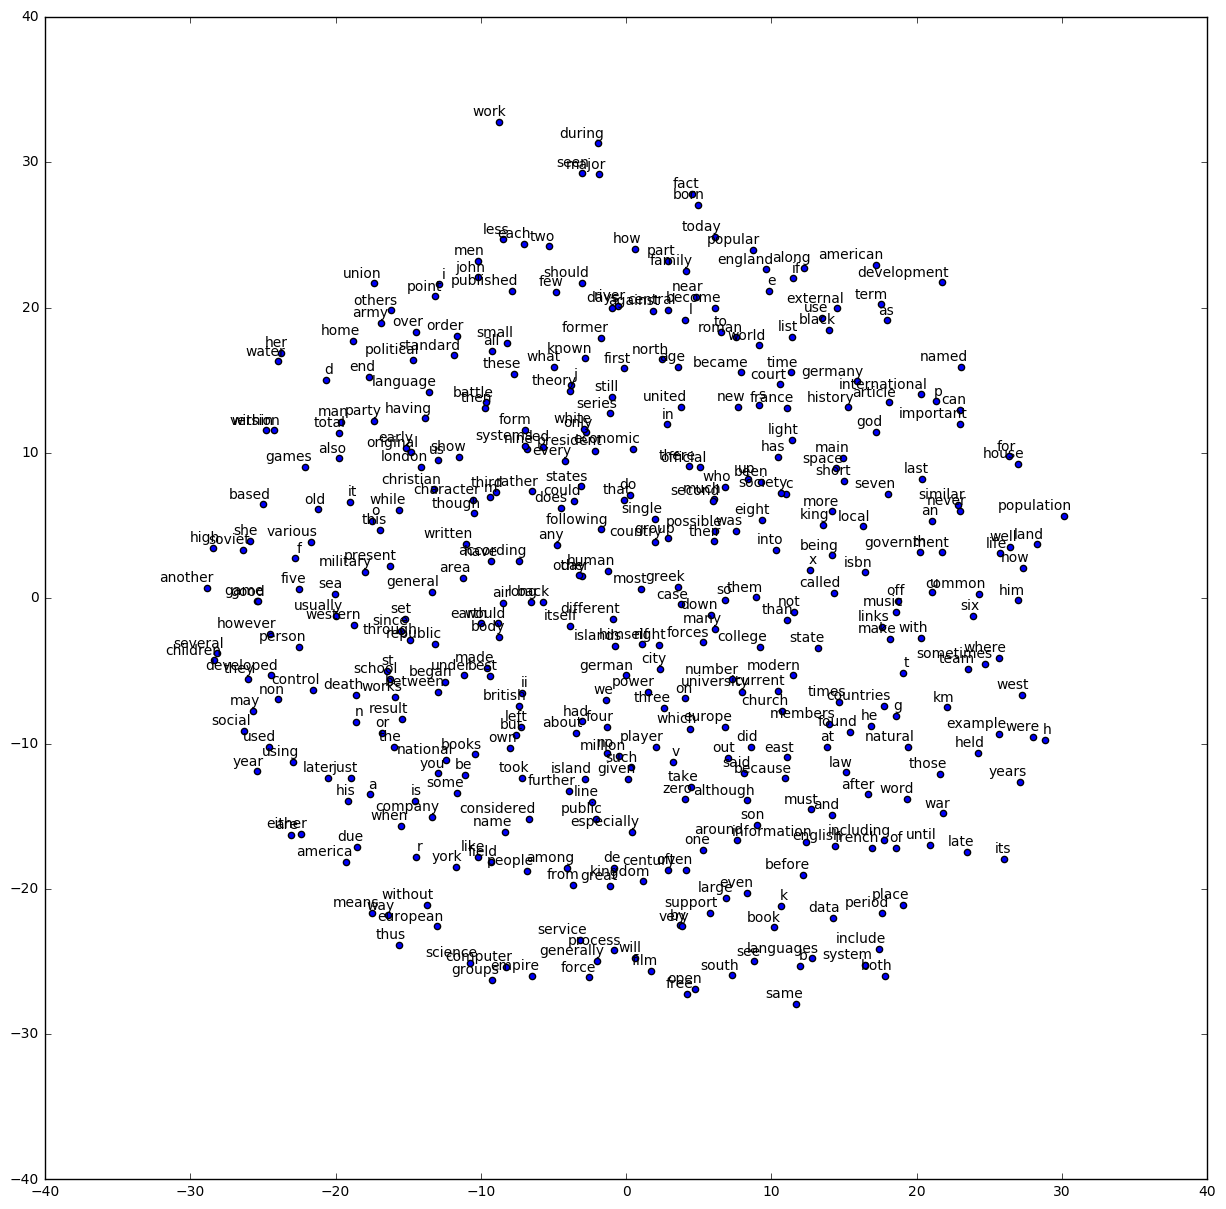

In [20]:
from sklearn.manifold import TSNE
from matplotlib import pylab

num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

words = [index_to_word[i] for i in range(1, num_points+1)]

pylab.figure(figsize=(15,15))
for i, label in enumerate(words):
    x, y = two_d_embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points",
                   ha="right", va="bottom")
pylab.show()